## MScA 31009 - Final Project Code

## Peter Fuentes Rosa

### Final Project Step by Step
#### Import Libraries and Packages

In [1]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score,confusion_matrix,classification_report,roc_auc_score,plot_roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC,SVC
import tensorflow as tf
from tensorflow import keras

#from PIL import Image
from tensorflow.keras import layers
from keras.models import Sequential,load_model
from keras.layers import Conv2D, LSTM, Dense, Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
import os, glob
import seaborn as sns

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)
#pd.set_option('precision', 2)
pd.set_option('mode.chained_assignment', None)
%matplotlib inline


### Import Data

##### For the Final project around the garment industry, our data is provided by UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees

In [2]:
df=pd.read_csv("G:\My Drive\Documents 1\MScA 31009\Final Project\garments_worker_productivity.csv")
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


### Data Cleaning/ Feature Enginering 

For our project, we are going clean/transforming the data by converting the data to numerica and eliminating excess data that is not needed for our analysis. 

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

Transform "Department" and "quarter" to numeric value and dropping "day" becuase that can be found with "date"

In [4]:
df['quarter'].unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [5]:
df.loc[df['quarter'] == 'Quarter1', 'quarter'] = '1'
df.loc[df['quarter'] == 'Quarter2', 'quarter'] = '2'
df.loc[df['quarter'] == 'Quarter3', 'quarter'] = '3'
df.loc[df['quarter'] == 'Quarter4', 'quarter'] = '4'
df.loc[df['quarter'] == 'Quarter5', 'quarter'] = '5'

In [6]:
df['department'].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

In [7]:
df.loc[df['department'] == 'sweing', 'department'] = '1'
df.loc[df['department'] == 'finishing ', 'department'] = '2'
df.loc[df['department'] == 'finishing', 'department'] = '2'

In [8]:
df['department'].unique()

array(['1', '2'], dtype=object)

In [9]:
df = df.drop(['day'], axis=1)

In [10]:
df.head()

,date,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,1,1,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,1,2,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,1,1,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,1,1,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,1,1,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


For the feature we wnat to predict, we are going to make bucked categories('Over_Expectations','On_target','Below_target','Under_Performing') based on the distribution of the actual_productivity to evaluate performance. We broke them into these 4 categories using the distribution below with the boxplot

In [11]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


<AxesSubplot:>

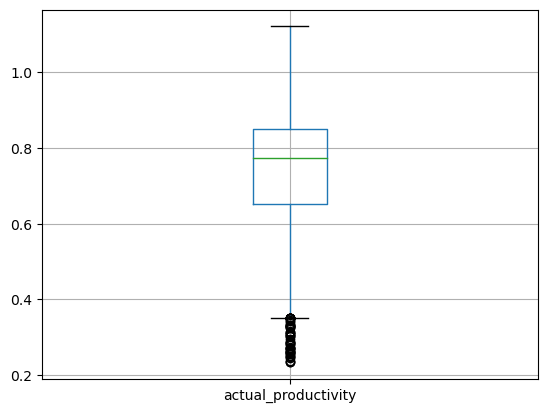

In [12]:
df.boxplot(column='actual_productivity')

In [13]:
df.loc[df['actual_productivity'] > 0.850253, 'Performance'] = 'Over_Expectations'
df.loc[(df['actual_productivity'] > 0.650307) & (df['actual_productivity'] <= 0.850253), 'Performance'] = 'On_target'
df.loc[(df['actual_productivity'] >.35) & (df['actual_productivity'] <= 0.650307), 'Performance'] = 'Below_target'
df.loc[df['actual_productivity'] <=.35, 'Performance'] = 'Under_Performing'

In [14]:
df.head(100)

,date,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Performance
0,1/1/2015,1,1,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,Over_Expectations
1,1/1/2015,1,2,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,Over_Expectations
2,1/1/2015,1,1,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,On_target
3,1/1/2015,1,1,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,On_target
4,1/1/2015,1,1,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,On_target
5,1/1/2015,1,1,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125,On_target
6,1/1/2015,1,2,2,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.755167,On_target
7,1/1/2015,1,1,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683,On_target
8,1/1/2015,1,1,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,0.753098,On_target
9,1/1/2015,1,1,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428,On_target


In addition, to help keep data consistency, we are going to tranform a few columns to numeric for the analysis and drop a column with more than half of missing values

In [15]:
df['department'] = df['department'].astype(float)
df['quarter'] = df['quarter'].astype(float)
df['date'] = pd.to_datetime(df['date'])
df = df.drop('wip', axis=1)

In [16]:
df_2=df
df = df.drop(['actual_productivity'], axis=1)
df.head()

,date,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,Performance
0,2015-01-01,1.0,1.0,8,0.80,26.16,7080,98,0.0,0,0,59.0,Over_Expectations
1,2015-01-01,1.0,2.0,1,0.75,3.94,960,0,0.0,0,0,8.0,Over_Expectations
2,2015-01-01,1.0,1.0,11,0.80,11.41,3660,50,0.0,0,0,30.5,On_target
3,2015-01-01,1.0,1.0,12,0.80,11.41,3660,50,0.0,0,0,30.5,On_target
4,2015-01-01,1.0,1.0,6,0.80,25.90,1920,50,0.0,0,0,56.0,On_target


In [17]:
df_2.head()

,date,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Performance
0,2015-01-01,1.0,1.0,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,Over_Expectations
1,2015-01-01,1.0,2.0,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,Over_Expectations
2,2015-01-01,1.0,1.0,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,On_target
3,2015-01-01,1.0,1.0,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,On_target
4,2015-01-01,1.0,1.0,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,On_target


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   float64       
 2   department             1197 non-null   float64       
 3   team                   1197 non-null   int64         
 4   targeted_productivity  1197 non-null   float64       
 5   smv                    1197 non-null   float64       
 6   over_time              1197 non-null   int64         
 7   incentive              1197 non-null   int64         
 8   idle_time              1197 non-null   float64       
 9   idle_men               1197 non-null   int64         
 10  no_of_style_change     1197 non-null   int64         
 11  no_of_workers          1197 non-null   float64       
 12  Performance            1197 non-null   object        
dtypes: 

### Data Exploration

#### We here get a more detailed view of the data and what elements feature are now presented

In [19]:
df.head()

,date,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,Performance
0,2015-01-01,1.0,1.0,8,0.80,26.16,7080,98,0.0,0,0,59.0,Over_Expectations
1,2015-01-01,1.0,2.0,1,0.75,3.94,960,0,0.0,0,0,8.0,Over_Expectations
2,2015-01-01,1.0,1.0,11,0.80,11.41,3660,50,0.0,0,0,30.5,On_target
3,2015-01-01,1.0,1.0,12,0.80,11.41,3660,50,0.0,0,0,30.5,On_target
4,2015-01-01,1.0,1.0,6,0.80,25.90,1920,50,0.0,0,0,56.0,On_target


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   float64       
 2   department             1197 non-null   float64       
 3   team                   1197 non-null   int64         
 4   targeted_productivity  1197 non-null   float64       
 5   smv                    1197 non-null   float64       
 6   over_time              1197 non-null   int64         
 7   incentive              1197 non-null   int64         
 8   idle_time              1197 non-null   float64       
 9   idle_men               1197 non-null   int64         
 10  no_of_style_change     1197 non-null   int64         
 11  no_of_workers          1197 non-null   float64       
 12  Performance            1197 non-null   object        
dtypes: 

In [21]:
df.describe()

,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,2.399332,1.422723,6.426901,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858
std,1.215535,0.494199,3.463963,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687
min,1.000000,1.000000,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1.000000,1.000000,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,2.000000,1.000000,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000
75%,3.000000,2.000000,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000
max,5.000000,2.000000,12.000000,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000


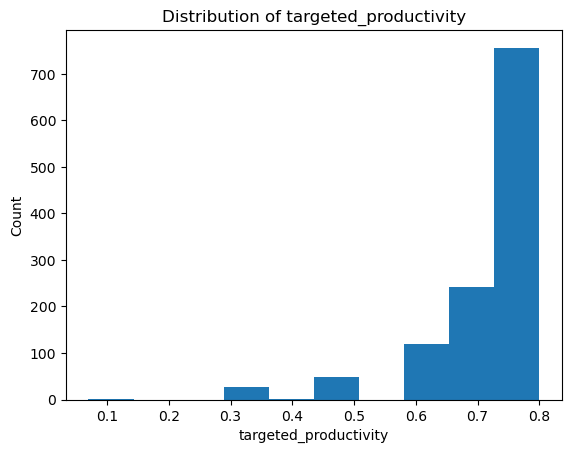

In [22]:
plt.hist(df['targeted_productivity'], bins=10)
plt.xlabel('targeted_productivity')
plt.ylabel('Count')
plt.title('Distribution of targeted_productivity')
plt.show()

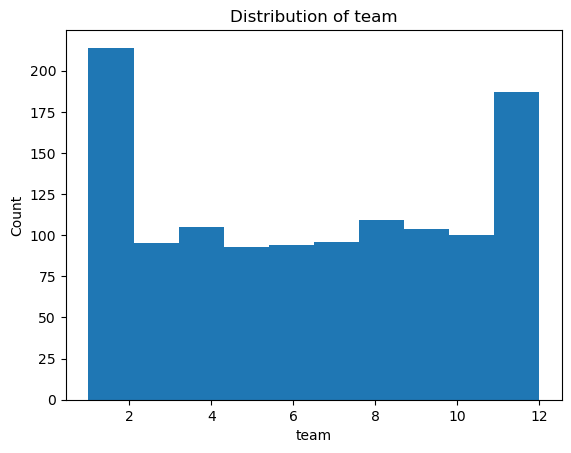

In [23]:
plt.hist(df['team'], bins=10)
plt.xlabel('team')
plt.ylabel('Count')
plt.title('Distribution of team')
plt.show()

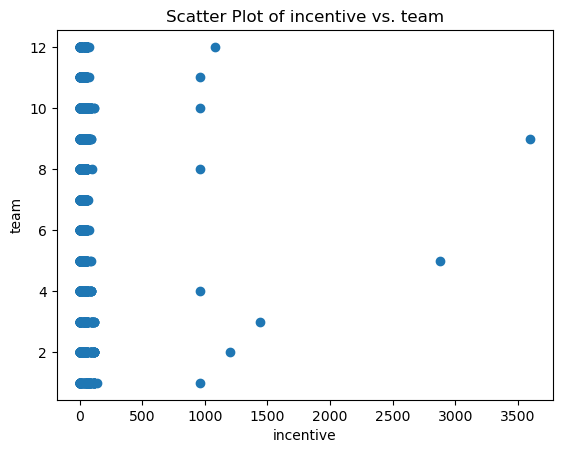

In [24]:
plt.scatter(df['incentive'], df['team'])
plt.xlabel('incentive')
plt.ylabel('team')
plt.title('Scatter Plot of incentive vs. team')
plt.show()

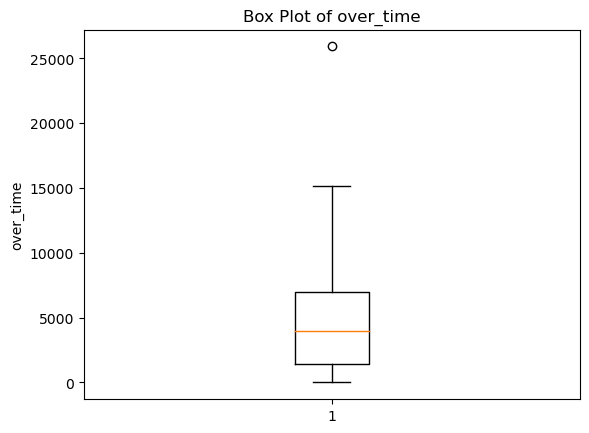

In [25]:
plt.boxplot(df['over_time'])
plt.ylabel('over_time')
plt.title('Box Plot of over_time')
plt.show()

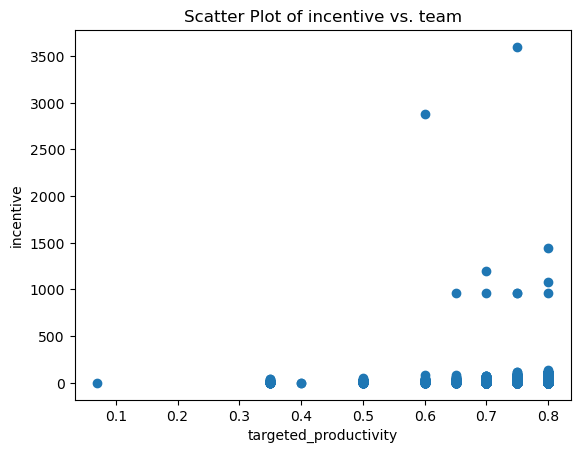

In [26]:
plt.scatter(df['targeted_productivity'], df['incentive'])
plt.xlabel('targeted_productivity')
plt.ylabel('incentive')
plt.title('Scatter Plot of incentive vs. team')
plt.show()

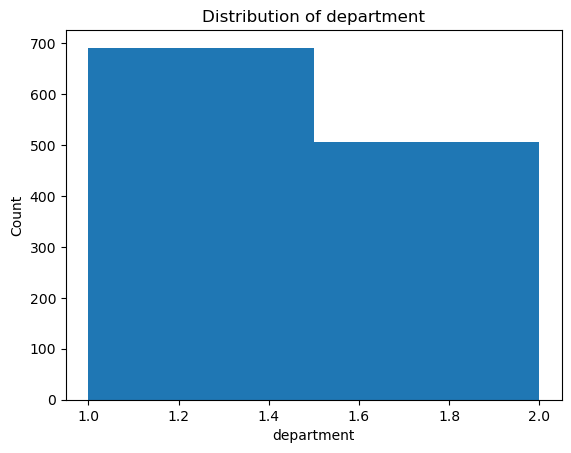

In [27]:
plt.hist(df['department'], bins=2)
plt.xlabel('department')
plt.ylabel('Count')
plt.title('Distribution of department')
plt.show()

In [28]:
corr_matrix_df=df.corr()

<AxesSubplot:>

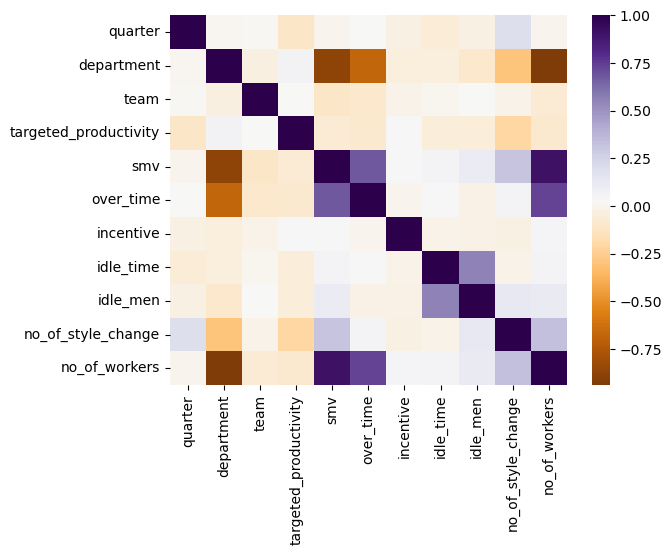

In [29]:
sns.heatmap(corr_matrix_df, cmap='PuOr')

<AxesSubplot:xlabel='smv', ylabel='no_of_workers'>

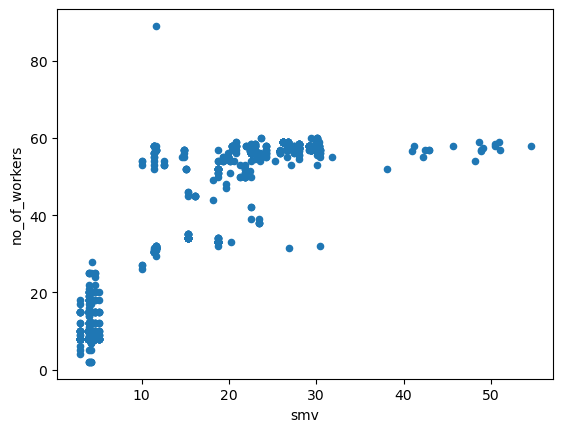

In [30]:
df.plot.scatter(x='smv', y='no_of_workers', marker='o')

<AxesSubplot:xlabel='over_time', ylabel='no_of_workers'>

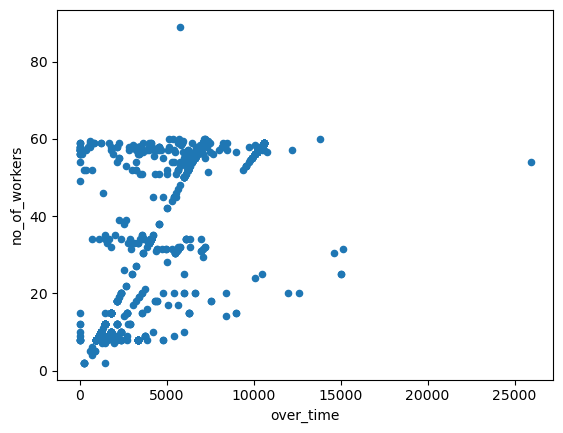

In [31]:
df.plot.scatter(x='over_time', y='no_of_workers', marker='o')

<AxesSubplot:xlabel='smv', ylabel='department'>

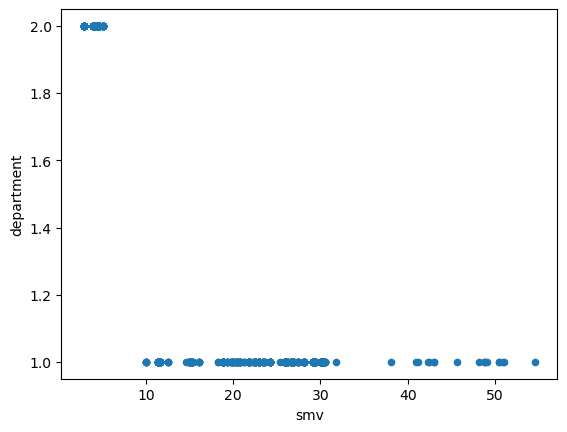

In [32]:
df.plot.scatter(x='smv', y='department', marker='o')

<AxesSubplot:xlabel='department', ylabel='no_of_workers'>

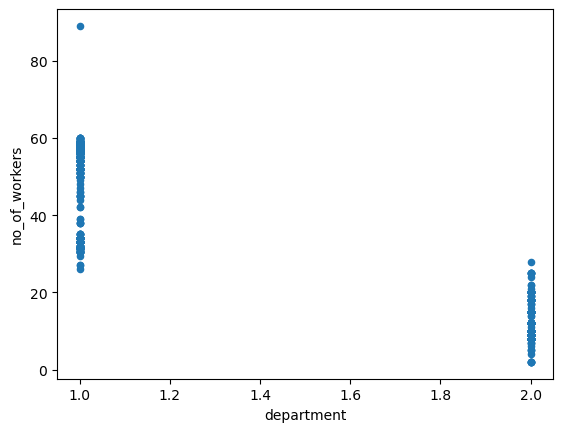

In [33]:
df.plot.scatter(x='department', y='no_of_workers', marker='o')

## Model Selection and Preparation

#### For model selection, we will break the data into train and test split and then starndardize the data first. After which  we will run a SVM model and a Deep Leraning Model and compare results. 

##### Because SVM dont handle time series data very well, we will do the SVM model without the time seires, and we can compare result to see if it impacts results

In [34]:
df_1= df.drop('date', axis=1)

In [36]:
Y= df_1['Performance']

In [37]:
X =df_1.drop(['Performance'], axis=1)

In [38]:
scaler=MinMaxScaler()

In [39]:
scaler.fit(X)

MinMaxScaler()

In [40]:
X_train_scaled = scaler.transform(X)

In [41]:
X_train_scaled

array([[0.        , 0.        , 0.63636364, ..., 0.        , 0.        ,
        0.65517241],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.06896552],
       [0.        , 0.        , 0.90909091, ..., 0.        , 0.        ,
        0.32758621],
       ...,
       [0.25      , 1.        , 0.54545455, ..., 0.        , 0.        ,
        0.06896552],
       [0.25      , 1.        , 0.72727273, ..., 0.        , 0.        ,
        0.14942529],
       [0.25      , 1.        , 0.45454545, ..., 0.        , 0.        ,
        0.04597701]])

In [42]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_train_scaled,Y,train_size=.75, test_size=0.25, random_state=42)

#### For our SVM model, we will be selecting Support Vector Machine Classifier + Linear Kernel + Grid Search

 Support Vector Machine Classifier + Linear Kernel + Grid Search

In [43]:
SVC_mod = SVC(kernel='linear',random_state=42)

In [44]:
parameters = {'C':np.arange(0.01, 10, 0.2) }

In [45]:
Grid_Search_CV_SVC = GridSearchCV(SVC_mod,parameters,n_jobs=-1)

In [46]:
Grid_Search_CV_SVC.fit(X_train_scaled,y_train)

GridSearchCV(estimator=SVC(kernel='linear', random_state=42), n_jobs=-1,
             param_grid={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81, 2.01,
       2.21, 2.41, 2.61, 2.81, 3.01, 3.21, 3.41, 3.61, 3.81, 4.01, 4.21,
       4.41, 4.61, 4.81, 5.01, 5.21, 5.41, 5.61, 5.81, 6.01, 6.21, 6.41,
       6.61, 6.81, 7.01, 7.21, 7.41, 7.61, 7.81, 8.01, 8.21, 8.41, 8.61,
       8.81, 9.01, 9.21, 9.41, 9.61, 9.81])})

In [47]:
Grid_Search_CV_SVC.best_params_

{'C': 9.41}

In [48]:
Grid_Search_CV_SVC.best_estimator_

SVC(C=9.41, kernel='linear', random_state=42)

In [49]:
y_pred_sklearn = Grid_Search_CV_SVC.best_estimator_.predict(X_test_scaled)

In [50]:
print(confusion_matrix(y_test,y_pred_sklearn))

[[ 13  29  11   0]
 [ 10 128  22   1]
 [  4  34  36   0]
 [  6   2   4   0]]


In [51]:
print(classification_report(y_test,y_pred_sklearn))

                   precision    recall  f1-score   support

     Below_target       0.39      0.25      0.30        53
        On_target       0.66      0.80      0.72       161
Over_Expectations       0.49      0.49      0.49        74
 Under_Performing       0.00      0.00      0.00        12

         accuracy                           0.59       300
        macro avg       0.39      0.38      0.38       300
     weighted avg       0.55      0.59      0.56       300



In [52]:
x_pred_sklearn = Grid_Search_CV_SVC.best_estimator_.predict(X_train_scaled)

In [53]:
print(confusion_matrix(y_train,x_pred_sklearn))

[[ 67  84  44   4]
 [ 18 349  70   1]
 [ 18  90 117   0]
 [ 10  16   4   5]]


In [54]:
print(classification_report(y_train,x_pred_sklearn))

                   precision    recall  f1-score   support

     Below_target       0.59      0.34      0.43       199
        On_target       0.65      0.80      0.71       438
Over_Expectations       0.50      0.52      0.51       225
 Under_Performing       0.50      0.14      0.22        35

         accuracy                           0.60       897
        macro avg       0.56      0.45      0.47       897
     weighted avg       0.59      0.60      0.58       897



##### Innitial view show model performing  not as well with only being able to predict around 60% of observations correctly. Right now, we see a good model fit with no underfitting or overfitting.

#### Improving Model with HyperTuning the Parameters

To better performance, we will try the model with adding additional parameters to improve classification capability and adding cross-folds on model.

In [55]:
SVC_mod_2 = SVC(kernel='linear',random_state=42)

In [56]:
parameters_2 = {'C':np.arange(0.01, 10, 0.2), 'gamma': [0.01,0.1,1,10,100]}

In [57]:
Grid_Search_CV_SVC_2 = GridSearchCV(SVC_mod_2,parameters_2,cv=5,verbose=0,n_jobs=-1)

In [58]:
Grid_Search_CV_SVC_2.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42), n_jobs=-1,
             param_grid={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81, 2.01,
       2.21, 2.41, 2.61, 2.81, 3.01, 3.21, 3.41, 3.61, 3.81, 4.01, 4.21,
       4.41, 4.61, 4.81, 5.01, 5.21, 5.41, 5.61, 5.81, 6.01, 6.21, 6.41,
       6.61, 6.81, 7.01, 7.21, 7.41, 7.61, 7.81, 8.01, 8.21, 8.41, 8.61,
       8.81, 9.01, 9.21, 9.41, 9.61, 9.81]),
                         'gamma': [0.01, 0.1, 1, 10, 100]})

In [59]:
Grid_Search_CV_SVC_2.best_params_

{'C': 9.41, 'gamma': 0.01}

In [60]:
y_pred_sklearn = Grid_Search_CV_SVC_2.best_estimator_.predict(X_test_scaled)

In [61]:
print(confusion_matrix(y_test,y_pred_sklearn))

[[ 13  29  11   0]
 [ 10 128  22   1]
 [  4  34  36   0]
 [  6   2   4   0]]


In [62]:
print(classification_report(y_test,y_pred_sklearn))

                   precision    recall  f1-score   support

     Below_target       0.39      0.25      0.30        53
        On_target       0.66      0.80      0.72       161
Over_Expectations       0.49      0.49      0.49        74
 Under_Performing       0.00      0.00      0.00        12

         accuracy                           0.59       300
        macro avg       0.39      0.38      0.38       300
     weighted avg       0.55      0.59      0.56       300



In [63]:
x_pred_sklearn = Grid_Search_CV_SVC_2.best_estimator_.predict(X_train_scaled)

In [64]:
print(confusion_matrix(y_train,x_pred_sklearn))

[[ 67  84  44   4]
 [ 18 349  70   1]
 [ 18  90 117   0]
 [ 10  16   4   5]]


In [65]:
print(classification_report(y_train,x_pred_sklearn))

                   precision    recall  f1-score   support

     Below_target       0.59      0.34      0.43       199
        On_target       0.65      0.80      0.71       438
Over_Expectations       0.50      0.52      0.51       225
 Under_Performing       0.50      0.14      0.22        35

         accuracy                           0.60       897
        macro avg       0.56      0.45      0.47       897
     weighted avg       0.59      0.60      0.58       897



##### Adding additional parameters and cross fold, looks to see that model did not have any improvements, thus best result has we have now. Now we pivot to see if a Deep Learning Model can performe better

### Deep Learning Model - Time Series with LSTMs

##### For this model, we will be looking at how well the Time Series model to see the capacity to predict the data accordingly

In [66]:
df_2.head()

,date,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Performance
0,2015-01-01,1.0,1.0,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,Over_Expectations
1,2015-01-01,1.0,2.0,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,Over_Expectations
2,2015-01-01,1.0,1.0,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,On_target
3,2015-01-01,1.0,1.0,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,On_target
4,2015-01-01,1.0,1.0,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,On_target


In [67]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   float64       
 2   department             1197 non-null   float64       
 3   team                   1197 non-null   int64         
 4   targeted_productivity  1197 non-null   float64       
 5   smv                    1197 non-null   float64       
 6   over_time              1197 non-null   int64         
 7   incentive              1197 non-null   int64         
 8   idle_time              1197 non-null   float64       
 9   idle_men               1197 non-null   int64         
 10  no_of_style_change     1197 non-null   int64         
 11  no_of_workers          1197 non-null   float64       
 12  actual_productivity    1197 non-null   float64       
 13  Per

In [68]:
df_2= df_2.drop('Performance', axis=1)

In [69]:
df_2 = df_2[['date', 'actual_productivity']]

In [70]:
df_2.set_index("date", inplace=True)

In [71]:
df_2

,actual_productivity
date,
2015-01-01,0.940725
2015-01-01,0.886500
2015-01-01,0.800570
2015-01-01,0.800570
2015-01-01,0.800382
2015-01-01,0.800125
2015-01-01,0.755167
2015-01-01,0.753683
2015-01-01,0.753098


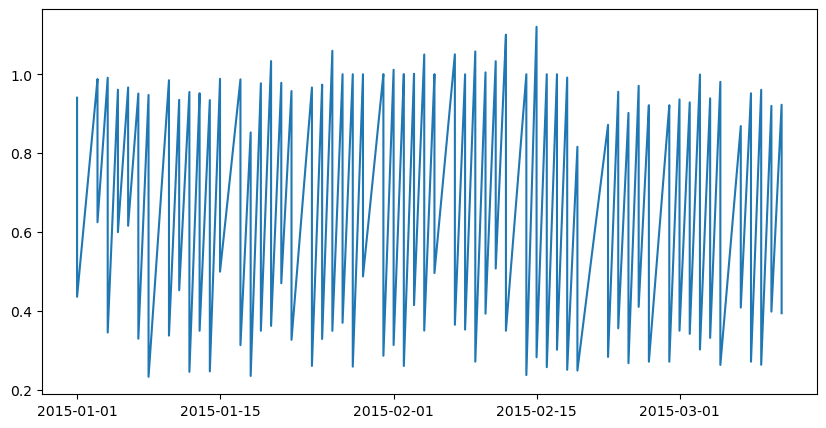

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(df_2.index, df_2["actual_productivity"])
plt.show()

In [73]:
scaler_2 = MinMaxScaler()
scaler_2.fit(df_2)

MinMaxScaler()

In [74]:
scaled_df_2_data = scaler_2.transform(df_2)

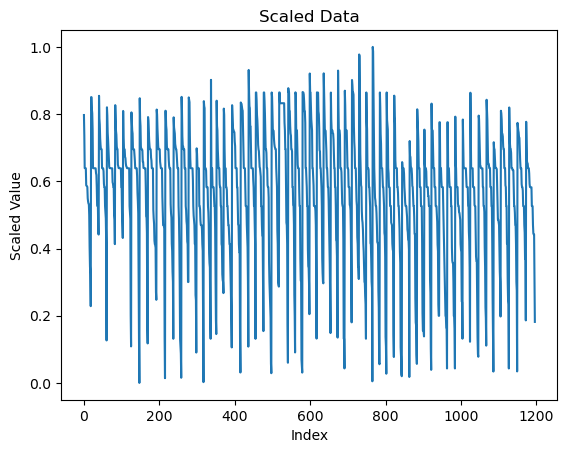

In [75]:
plt.plot(scaled_df_2_data)
plt.title('Scaled Data')
plt.xlabel('Index')
plt.ylabel('Scaled Value')
plt.show()

In [76]:
from typing import Tuple


def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split
    
    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set
    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy
arrays
    """
    y = data[Y_var].tolist()
    
    X, Y = [], []
    
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])
            
    X, Y = np.array(X), np.array(Y)
    
    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Creating training and test sets
    X_train = X
    X_test = []
    
    Y_train = Y
    Y_test = []
    
    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]
        
        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]
        
    return X_train, X_test, Y_train, Y_test

In [77]:
lag = 3
test_ratio = 0.15

data = scaled_df_2_data
#data.sort_values(by="Datetime", inplace=True)
data = pd.DataFrame(data)


X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [78]:
X_train.shape

(1015, 3, 1)

In [79]:
model_4 = keras.Sequential()

In [80]:
model_4.add(LSTM(units=64,input_shape=(3, 1)))

In [81]:
model_4.add(Dense(1))

In [82]:
model_4.compile(optimizer='adam', loss='mse')

In [83]:
model_4.fit(x=X_train, y= Y_train, use_multiprocessing=True)

32/32 [==============================] - 4s 6ms/step - loss: 0.1401


In [84]:
y_pred = model_4.predict(X_test)

In [85]:
y_pred

array([[0.5880714 ],
       [0.58792984],
       [0.5801458 ],
       [0.56757826],
       [0.54166776],
       [0.52070117],
       [0.48324502],
       [0.4286554 ],
       [0.45987126],
       [0.54864246],
       [0.71261406],
       [0.6560189 ],
       [0.62404126],
       [0.6239466 ],
       [0.62384397],
       [0.61601704],
       [0.6034186 ],
       [0.58806306],
       [0.5879232 ],
       [0.5804287 ],
       [0.56811774],
       [0.552915  ],
       [0.54213065],
       [0.5153096 ],
       [0.47714254],
       [0.45361412],
       [0.43591297],
       [0.39700255],
       [0.33741003],
       [0.2947421 ],
       [0.3741089 ],
       [0.52591735],
       [0.7141    ],
       [0.6916752 ],
       [0.6601124 ],
       [0.63682836],
       [0.6274041 ],
       [0.62574273],
       [0.6239888 ],
       [0.6238346 ],
       [0.6237303 ],
       [0.61587673],
       [0.60333306],
       [0.5801851 ],
       [0.567489  ],
       [0.5496915 ],
       [0.5313248 ],
       [0.495

In [86]:
y_pred = scaler_2.inverse_transform(y_pred)
y_test = scaler_2.inverse_transform(Y_test.reshape(-1, 1))

In [87]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 0.14979407198667016


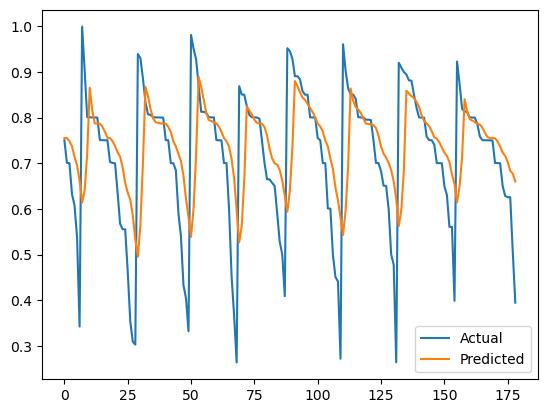

In [88]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()